# Data exploration and visualization 

## Preperations 
Load required libaries and the cleaned & outlier corrected data. 

In [1]:
# Basic imports
import pandas as pd
import numpy as np

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

In [2]:
# load clean and outlier corrected data
df = pd.read_csv("data/data_clean.csv")

# set random state
RSEED = 42

---
## Number of projects per creator

Some creators (which are identified by the same creator-ID) have more than one project. We wanted to know if such a experienced creator has a higher success rate. Therefore we took at look at the success rate of creators with one project and compared it to the rate of creators with more projects. 

Text(0.5, 0, 'Number of projects per creator')

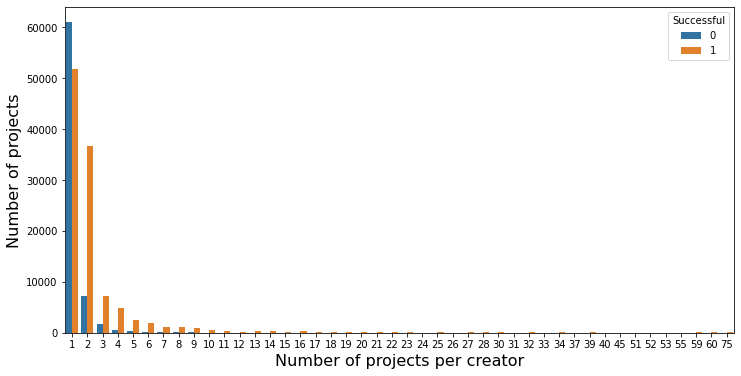

In [3]:
# take a initial look at the number of successful and failed projects per number of projects per creator
fig, ax = plt.subplots(figsize = (12,6))
sns.countplot(x='creator_num_projects', hue='state', data=df);
plt.legend(loc='upper right', title='Successful');
ax.set_ylabel('Number of projects', fontsize = 16)
ax.set_xlabel('Number of projects per creator', fontsize = 16)

In [4]:
# create bins to select 1, 2, 3, 4 and more than 4 projects per creator
fixed_bins = [0, 1, 2, 3, 4, 5]
lab = ['1', '2', '3', '4', '>4']

# convert the creator_num_projects column to a categorical variable (creator_num_projects_cat) according to the bins above
df['creator_num_projects_cat'] = pd.cut(df['creator_num_projects'], bins=fixed_bins, labels=lab)

# create a variable with contains the success rate per creator_num_projects_cat
success_num_project = df[['state','creator_num_projects_cat']].groupby('creator_num_projects_cat').mean()

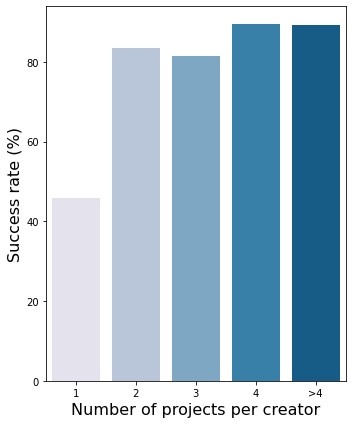

In [5]:
# barplot success rate per creator_num_projects_cat
fig, ax = plt.subplots(figsize = (5,6))
sns.barplot(y=success_num_project.state*100, x=success_num_project.index, palette="PuBu")
ax.set_ylabel('Success rate (%)', fontsize = 16)
ax.set_xlabel('Number of projects per creator', fontsize = 16)

# save figure
plt.tight_layout()
fig.savefig('plots/success_number_projects_creator.png', dpi=300)

---
### Number of projects and success rate per country
Kickstarter is active in different countries around the world. The number of projects and the success rate also differs between the countries. Here we illustrate these two variables combined in a map:

In [6]:
# load csv with all latitude and longitude data 
coordinates = pd.read_csv("data/world_country_and_usa_states_latitude_and_longitude_values.csv")

# remove irrelevant information from these set
coordinates = coordinates.drop(["usa_state_code", "usa_state_latitude", "usa_state_longitude", "usa_state"], axis=1)

In [7]:
# prepare dataframes gouped by coutry 
country_count = df.groupby('country').count()
country_sum = df.groupby('country').sum()
country_mean = df.groupby('country').mean()

In [8]:
# get index (which is the coutry ID) as first column in new dataframe
df_country = pd.DataFrame(data=country_count.index)

# merge bakers_count from country_count (doesn't matter, count is for every column the same) to get the number of projects per country
# and rename the column
df_country = df_country.merge(country_count['backers_count'],  how ='left', on = 'country')
df_country.rename(columns={'backers_count':'number_projects'}, inplace=True)

# merge state from country_sum (originally values are 1[sucessful] or 0[failed], so sum gets number of successful projects) 
# to get the number of sucessful projects per country and rename the column
df_country = df_country.merge(country_sum['state'],  how ='left', on = 'country')
df_country.rename(columns={'state':'number_successful_projects'}, inplace=True)

# calculate the number of failed projects from number projects and number successful projects
df_country['number_failed_projects'] = df_country['number_projects']-df_country['number_successful_projects']

# calculate the success rate per country from the number projects and number of successful projects
df_country['success_rate'] = (df_country['number_successful_projects']/df_country['number_projects'])

# rename country for merging with coordinates csv
df_country.rename(columns={'country':'country_code'}, inplace=True)

# merge coordinates (latitude, longitude and country) to df_country for plotting
df_country = df_country.merge(coordinates,  how ='left', on = 'country_code')

# create new column for plotting the number of projects (value multiplied by 0.5)
df_country['number_projects_corr_plot'] = df_country['number_projects']*0.5

# create a seperate new column for plotting the number of projects for US
# and delete US entry in this column
df_country['number_projects_corr_plot_US'] = df_country['number_projects_corr_plot'] 
df_country.loc[21, 'number_projects_corr_plot'] = np.nan

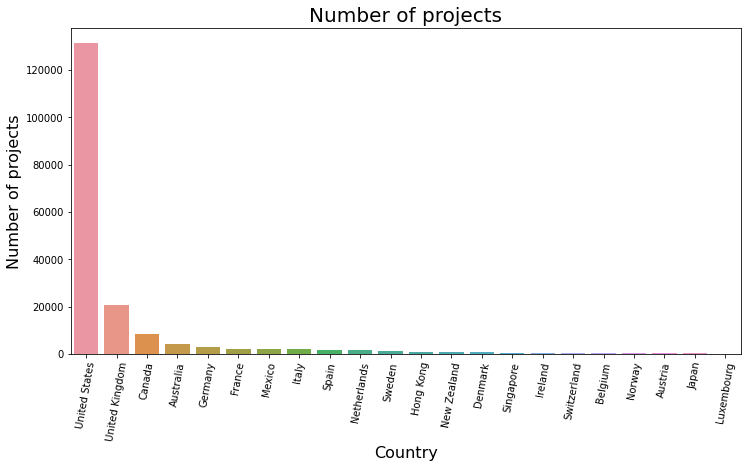

In [9]:
# barplot success rate
fig, ax = plt.subplots(figsize = (12,6))
sns.barplot(y=df_country.number_projects, x=df_country.country,
           order=df_country.sort_values('number_projects',ascending = False).country);
plt.xticks(rotation='80');
ax.set_ylabel('Number of projects', fontsize = 16)
ax.set_xlabel('Country', fontsize = 16)
ax.set_title('Number of projects', fontsize = 20);

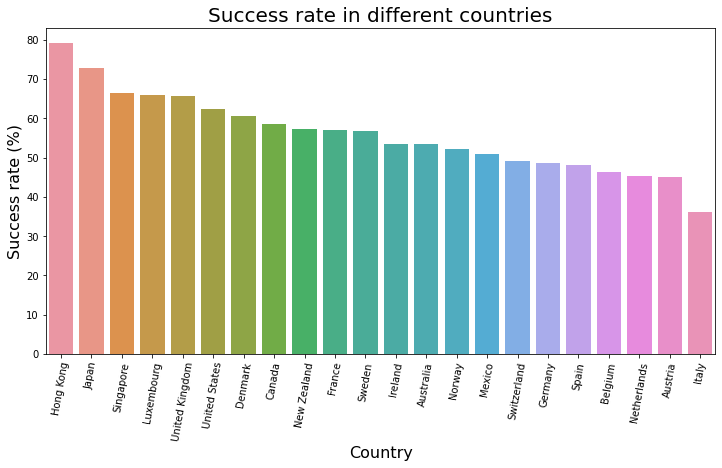

In [10]:
# barplot success rate
fig, ax = plt.subplots(figsize = (12,6))
sns.barplot(y=df_country.success_rate*100, x=df_country.country,
           order=df_country.sort_values('success_rate',ascending = False).country);
plt.xticks(rotation='80');
ax.set_ylabel('Success rate (%)', fontsize = 16)
ax.set_xlabel('Country', fontsize = 16)
ax.set_title('Success rate in different countries', fontsize = 20);

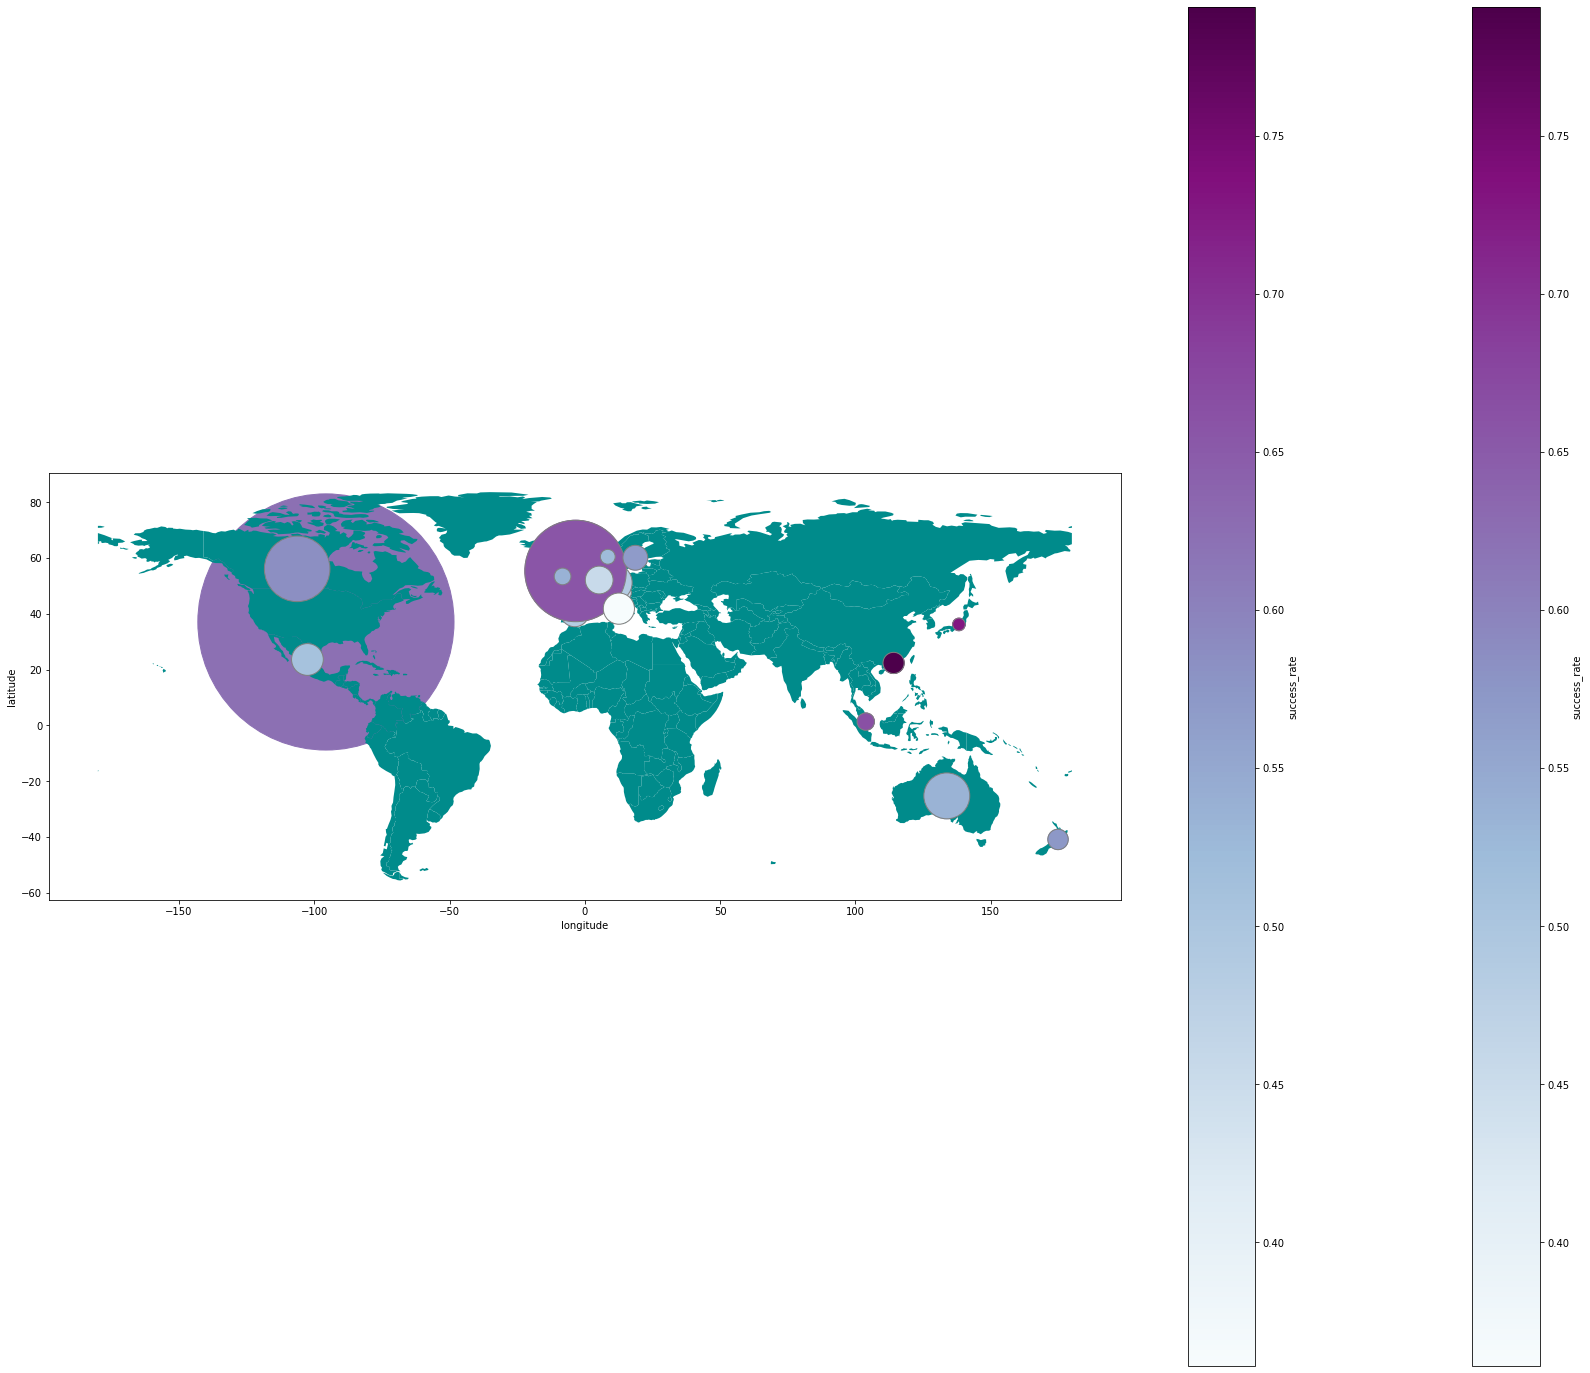

In [11]:
# create a map with a scatterplot
fig, ax = plt.subplots(figsize=(30,25))

# prepare the world map
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
world = world[world.name!="Antarctica"]

# plot scatterpoints with the size according to the number of projects and the color according to the success rate
# including the US as it too large to be plotted above the map
df_country.plot(x="longitude", y="latitude", kind="scatter", s=df_country['number_projects_corr_plot_US'], ax=ax, c="success_rate", cmap='BuPu')

# plot map on axis
world.plot(color="darkcyan", ax=ax)

# plot scatterpoints with the size according to the number of projects and the color according to the success rate
# excluding the US as it too large to be plotted above the map
df_country.plot(x="longitude", y="latitude", kind="scatter", c="success_rate", s=df_country['number_projects_corr_plot'], ax=ax, cmap='BuPu', edgecolors='grey')

# save the plot
fig.savefig('plots/world.png', dpi=500)

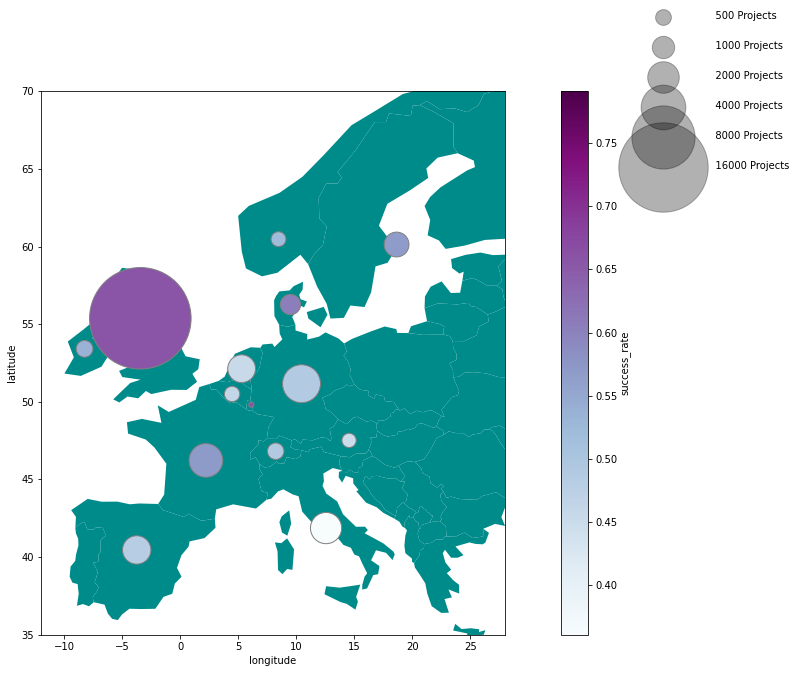

In [12]:
# plot just central europe with success rare (color) and number_projects_corr_plot (size)
fig, ax = plt.subplots(figsize=(20,10))

# prepare the map of europe
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
europe = world[world.continent=="Europe"]

# limit graph for central europe
plt.ylim(ymax = 70, ymin = 35)
plt.xlim(xmax = 28, xmin = -12)

# plot map on axis
europe.plot(color="darkcyan", ax=ax)

# plot success rate as color and number of projects as size of the points
df_country.plot(x="longitude", y="latitude", kind="scatter", s=df_country['number_projects_corr_plot'], c="success_rate", ax=ax, cmap='BuPu', edgecolors='grey')

# create a legend for the size of the scatterpoints
for area in [250, 500, 1000, 2000, 4000, 8000]:
    plt.scatter([], [], c='k', alpha=0.3, s=area,
                label='           ' + str(area*2) + ' Projects')
plt.legend(scatterpoints=1, frameon=False, labelspacing=2, title='', loc=6, bbox_to_anchor=(1.3, 1.0))

# save the plot
fig.savefig('plots/europe.png', dpi=500)

---

## Staff picked
Kickstarter selects some projects as *'staff pick'*. These projects get highlighted on their site. We wanted to know if this label is good in terms of success of the project. Here we show if the projects which are staff picked are more successful than non-staff picked ones and if the projects which are labeled with staff pick raise more money or have more backers. 

In [13]:
# prepare dataframes goupby coutry 
staffpick_mean = df.groupby('staff_pick').mean()
staffpick_sum = df.groupby('staff_pick').sum()

In [16]:
df_staff = pd.DataFrame(data=staffpick_mean.index)

# merge staff_pick from staffpick_count to get the number of projects per for projects with staff pick and without
# and rename the column
df_staff['number_projects'] = df.groupby('staff_pick').count().state

# merge state from staffpick_sum (originally values are 1[sucessful] or 0[failed], so sum gets number of successful projects) 
# to get the number of sucessful projects for projects with staff pick and without
df_staff = df_staff.merge(staffpick_sum['state'],  how ='left', on = 'staff_pick')
df_staff.rename(columns={'state':'successful'}, inplace=True)

# calculate the number of failed projects from number projects and number successful projects
df_staff['failed'] = df_staff['number_projects']-df_staff['successful']

# calculate the success rate per country from the number projects and number of successful projects
df_staff['success_rate'] = (df_staff['successful']/df_staff['number_projects'])

# merge backers_count from staffpick_mean to get the mean number of backers per project with staff pick and without
df_staff = df_staff.merge(staffpick_mean['backers_count'],  how ='left', on = 'staff_pick')
df_staff.rename(columns={'backers_count':'mean_number_backers'}, inplace=True)

df_staff = df_staff.merge(staffpick_mean['usd_pledged'],  how ='left', on = 'staff_pick')
df_staff.rename(columns={'usd_pledged':'mean_usd_pledged'}, inplace=True)

df_staff = df_staff.merge(staffpick_mean['goal_usd'],  how ='left', on = 'staff_pick')
df_staff.rename(columns={'goal_usd':'mean_goal_usd'}, inplace=True)

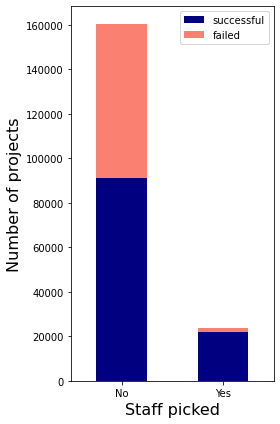

In [17]:
# plot the nuber of successful and failed projects (stacked) with and without staff picked label
fig, ax = plt.subplots(figsize = (4,6))

# create the stacked barplot
df_staff[['successful', 'failed']].plot(kind='bar', stacked=True, ax=ax, color = ['navy','salmon'])

# set axis labels
ax.set_ylabel('Number of projects', fontsize = 16)
ax.set_xlabel('Staff picked', fontsize = 16)
ax.set_title('', fontsize = 20)

# change levels of staff picked (befor 0 or 1)
labels = ['No', 'Yes']
ax.set_xticklabels(labels)
plt.xticks(rotation='0');
plt.tight_layout()
fig.savefig('plots/staff_picked_projects.png', dpi=300)

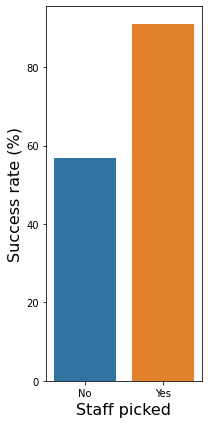

In [18]:
# plot the success rate for staff picked or not staff picked
fig, ax = plt.subplots(figsize = (3,6))

# create the plot
sns.barplot(y=df_staff.success_rate*100, x=df_staff.staff_pick);

# set axis labels
ax.set_ylabel('Success rate (%)', fontsize = 16)
ax.set_xlabel('Staff picked', fontsize = 16)
ax.set_title('', fontsize = 20)

# change levels of staff picked (befor 0 or 1)
labels = ['No', 'Yes']
ax.set_xticklabels(labels)
plt.xticks(rotation='0');
plt.tight_layout()
fig.savefig('plots/staff_picked_success_rate.png', dpi=300)

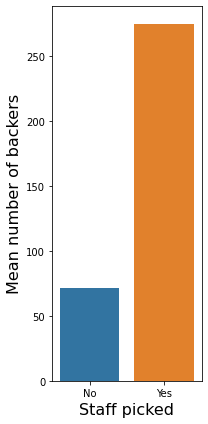

In [19]:
# plot the mean number of backers for staff picked or not staff picked
fig, ax = plt.subplots(figsize = (3,6))

# create the plot
sns.barplot(y=df_staff.mean_number_backers, x=df_staff.staff_pick);

# set axis labels
ax.set_ylabel('Mean number of backers', fontsize = 16)
ax.set_xlabel('Staff picked', fontsize = 16)
ax.set_title('', fontsize = 20)

# change levels of staff picked (befor 0 or 1)
labels = ['No', 'Yes']
ax.set_xticklabels(labels)
plt.xticks(rotation='0');
plt.tight_layout()
fig.savefig('plots/staff_picked_backers.png', dpi=300)

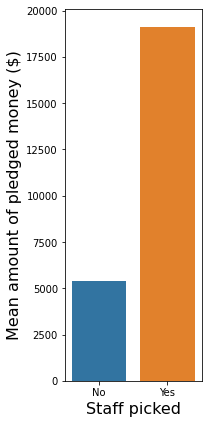

In [20]:
# plot the mean number pledged money for staff picked or not staff picked
fig, ax = plt.subplots(figsize = (3,6))

# create the plot
sns.barplot(y=df_staff.mean_usd_pledged, x=df_staff.staff_pick);

# set axis labels
ax.set_ylabel('Mean amount of pledged money ($)', fontsize = 16)
ax.set_xlabel('Staff picked', fontsize = 16)
ax.set_title('', fontsize = 20)

# change levels of staff picked (befor 0 or 1)
labels = ['No', 'Yes']
ax.set_xticklabels(labels)
plt.xticks(rotation='0');
plt.tight_layout()
fig.savefig('plots/staff_picked_pledged.png', dpi=300)

---
## Category
Kickstarter is focused on creative projects. But which categories have the highest success rate? Here we illustrate the success of the different main categories. 

In [21]:
# prepare dataframes goupby coutry 
category_count = df.groupby('main_category').count()
category_mean = df.groupby('main_category').mean()
category_sum = df.groupby('main_category').sum()

In [22]:
df_category = pd.DataFrame(data=category_count.index)

# merge staff_pick from staffpick_count to get the number of projects per for projects with staff pick and without
# and rename the column
df_category = df_category.merge(category_count['state'],  how ='left', on = 'main_category')
df_category.rename(columns={'state':'number_projects'}, inplace=True)

# merge state from staffpick_sum (originally values are 1[sucessful] or 0[failed], so sum gets number of successful projects) 
# to get the number of sucessful projects for projects with staff pick and without
df_category = df_category.merge(category_sum['state'],  how ='left', on = 'main_category')
df_category.rename(columns={'state':'successful'}, inplace=True)

# calculate the number of failed projects from number projects and number successful projects
df_category['failed'] = df_category['number_projects']-df_category['successful']

# calculate the success rate per country from the number projects and number of successful projects
df_category['success_rate'] = (df_category['successful']/df_category['number_projects'])

# merge backers_count from staffpick_mean to get the mean number of backers per project with staff pick and without
df_category = df_category.merge(category_mean['backers_count'],  how ='left', on = 'main_category')
df_category.rename(columns={'backers_count':'mean_number_backers'}, inplace=True)

df_category = df_category.merge(category_mean['usd_pledged'],  how ='left', on = 'main_category')
df_category.rename(columns={'usd_pledged':'mean_usd_pledged'}, inplace=True)

df_category = df_category.merge(category_mean['goal_usd'],  how ='left', on = 'main_category')
df_category.rename(columns={'goal_usd':'mean_goal_usd'}, inplace=True)

In [23]:
# function to color the bars according to a feature
def colors_from_values(values, palette_name):
    # normalize the values to range [0, 1]
    normalized = (values - min(values)) / (max(values) - min(values))
    # convert to indices
    indices = np.round(normalized * (len(values) - 1)).astype(np.int32)
    # use the indices to get the colors
    palette = sns.color_palette(palette_name, len(values))
    return np.array(palette).take(indices, axis=0)

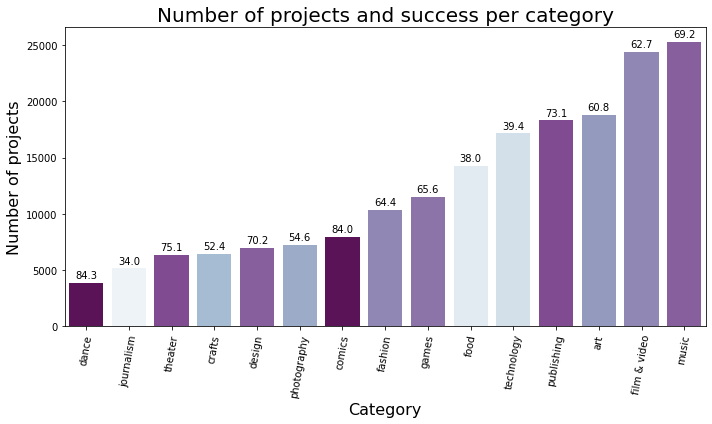

In [24]:
df_category = df_category.sort_values('number_projects', ascending=True)

# barplot success rate
fig, ax = plt.subplots(figsize = (10,6))

DF = df_category.sort_values('number_projects', ascending=False)
plot = sns.barplot(y=df_category.number_projects, x=df_category.main_category, palette=colors_from_values(df_category.success_rate, "BuPu"))

cat_values = list(df_category['number_projects'] + 400)
for i, row in enumerate(df_category.success_rate):
    plot.text(x = i, y = cat_values[i], s=round(row*100,1), color='black', ha="center")

#for index, row in df_category.iterrows():
#    plot.text(index, row.success_rate, round(row.success_rate,2), color='black', ha="center")

plt.xticks(rotation='80');
ax.set_ylabel('Number of projects', fontsize = 16)
ax.set_xlabel('Category', fontsize = 16)
ax.set_title('Number of projects and success per category', fontsize = 20)

plt.tight_layout()
fig.savefig('plots/plot1.png', dpi=300)

---
## Frequency of words in the blurb text
The blurb text gives a short introduction about the project. Certain words used in the blurb text could contribute to the success or failure of a project. Before starting a sentiment analysis we aim to illustrate the frequency of different words in the blurb text of successful and failed prjects. Therefore word-clouds were used.

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 184113 entries, 0 to 184112
Data columns (total 30 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   Unnamed: 0                184113 non-null  int64   
 1   backers_count             184113 non-null  int64   
 2   blurb                     184113 non-null  object  
 3   country                   184113 non-null  object  
 4   id                        184113 non-null  int64   
 5   name                      184113 non-null  object  
 6   staff_pick                184113 non-null  int64   
 7   state                     184113 non-null  int64   
 8   usd_pledged               184113 non-null  float64 
 9   usd_type                  184113 non-null  object  
 10  yr_launched               184113 non-null  int64   
 11  mo_launched               184113 non-null  int64   
 12  wd_launched               184113 non-null  int64   
 13  yr_deadline               184

In [33]:
# install wordcloud
#!pip install wordcloud

# import package and its set of stopwords
from wordcloud import WordCloud, STOPWORDS

subset = df.sample(n=10000, random_state=42, axis=0)
success_blurb = subset[["state","blurb"]].groupby("state").sum()
success_blurb.reset_index(inplace = True)

success_words = success_blurb.loc[0,"blurb"]
loser_words = success_blurb.loc[1,"blurb"]

In [34]:
stopwords = set(STOPWORDS)

# instantiate a word cloud object

success_wc = WordCloud(
    background_color = 'white',
    max_words = 200000,
    stopwords = stopwords,
    colormap = "viridis"
)

loser_wc = WordCloud(
    background_color = 'white',
    max_words = 200000,
    stopwords = stopwords,
    colormap = "inferno"
)

# generate the word cloud
success_wc.generate(success_words)
loser_wc.generate(loser_words)

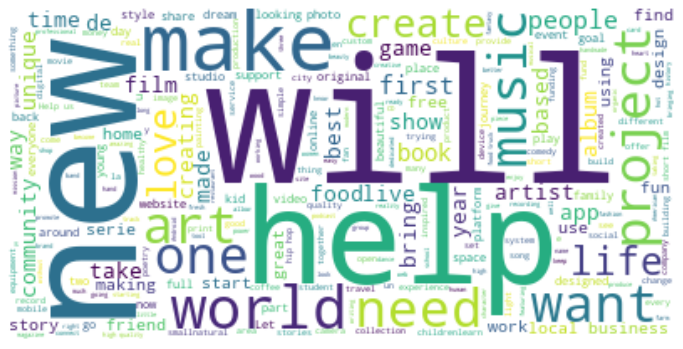

In [47]:
# wordcloud with words from successful projects
fig, ax = plt.subplots(figsize = (18,18))

# display the cloud
plt.imshow(success_wc, interpolation='bilinear')
plt.axis('off')
plt.savefig('plots/positive_words.png', dpi=300)

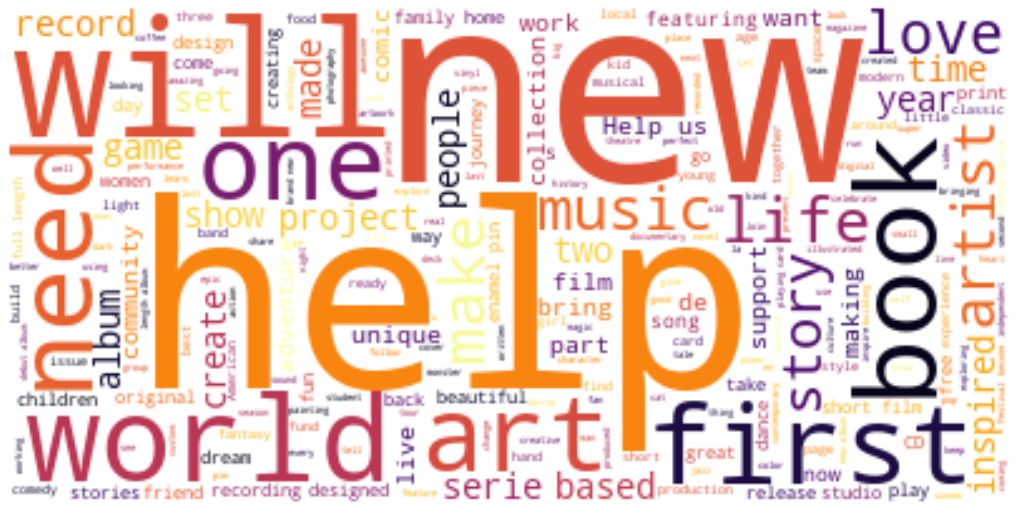

In [49]:
# wordcloud with words from failed projects
fig, ax = plt.subplots(figsize = (18,18))

# display the cloud
plt.imshow(loser_wc, interpolation='bilinear')
plt.axis('off')
plt.savefig('plots/negative_words.png', dpi=300)